<img src="./documentation/images/ibm-logo.png" alt="ibm-logo" align="center" style="width: 200px;"/>

**AI ENTERPRISE WORKFLOW CERTIFICATION**

<hr />

### Capstone Project - Model Building and Selection

# Introduction

This part of the case study will focus on the next two stages in the enterprise workflow, namely data transformations and models. This part of the workflow will be treated slightly differently than previous case studies as these are time-series data, but the general procedure and best practices remain the same. These materials will provide the necessary guidance so that you can apply one of the supervised learning approaches that we have already discussed. However, you will also be encouraged to explore some of the time-series modeling tools available.

Time-series data are commonly encountered in data science. In particular, the field of finance, signal processing, weather and other fields regularly deal with data formatted in this way. The goal of this case study is **time-series forecasting**, which can be thought of as the use of a model to predict future values based on previously observed values. So we could try to predict purchases, number of views or the feature most closely related to our business opportunity, revenue.

### Tasks

1. State the different modeling approaches that you will compare to address the business opportunity.
2. Iterate on your suite of possible models by modifying data transformations, pipeline architectures, hyperparameters and other relevant factors.
3. Re-train your model on all of the data using the selected approach and prepare it for deployment.
4. Articulate your findings in a summary report.

_**HINT**: To standardize the approach across models ensure that your model predicts the next 30 days for any given point in time. For supervised learning, the total revenue over the next thirty days can be represented as a single number._

# On time-series analysis

We have used TensorFlow, scikit-learn, and Spark ML as the main ways to implement models. Time-series analysis has been around a long time and there are a number of specialized packages and software to help facilitate model implementation. In the case of our business opportunity, it is required that we predict the next point or determine a reasonable value for next month's revenue. If we only had revenue, we could engineer features with revenue for the previous day, previous week, previous month and previous three months, for example. This provides features that machine learning models such as random forests or boosting could use to capture the underlying patterns or trends in the the data. You will likely spend some time optimizing this feature engineering task on a case-by-case basis.

Predicting the next element in a time-series is in line with the other machine learning tasks that we have encountered in this specialization. One caveat to this approach is that sometimes we wish to project further into the future. Although, it is not a specific request of management in the case of this business opportunity, you may want to consider forecasting multiple points into the future, say three months or more. To do this, you have two main categories of methods: 'recursive forecasting' and 'ensemble forecasting'.

In recursive forecasting, you will append your predictions to the feature matrix and roll forward until you get to the desired number of forecasts in the future. In the ensemble approach, you will use separate models for each point. It is possible to use a hybridization of these two ideas as well. If you wish to take your forecasting model to the next level, try to project several months into the future with one or both of these ideas.

Also, be aware that the assumptions of line regression are generally invalidated when using time-series data because of auto-correlation. The engineered features are derived mostly from revenue which often means that there is a high degree of correlation. You will get further with more sophisticated models to in combination with smartly engineered features.

# Deliverables

### Data Engineering

* **Engineer Features with Rolling Window**: When forecasting the revenues only the realized (historical) values are known. The unrealized values are not given. Therefore for each instance in the dataset I have to come up with additional features that refer to historical values.


* **Target Value Rolling Window**: To standardize the approach across models ensure the target is the sum of revenues over the next 30 days for any given point in time. For supervised learning, the total revenue over the next thirty days can be represented as a single number

In [1]:
%%writefile data_engineering.py
#!/usr/bin/env python

import os
import re
import time
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

## import function to load feature matrix
from data_ingestion import load_feature_matrix
from data_ingestion import DEV

class FeatureEngineer(BaseEstimator, TransformerMixin):
    """
    apply rolling window to engineer features
    """
    def __init__(self, shift=1, attributes=['revenue'], func="sum"):
        self.shift = shift
        self.attributes = attributes
        self.freq = "{}D".format(self.shift)
        self.func = func
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        ## set time as index
        X_ts = X.set_index(["invoice_date"])
        
        ## rolling window
        if self.func == "sum":
            X_eng = X_ts[self.attributes].rolling(self.freq, closed="left").sum()
        else:
            X_eng = X_ts[self.attributes].rolling(self.freq, closed="left").mean()
        
        ## merge with initial dataset and fill NAs
        X_eng = X_ts.merge(X_eng, left_index=True, right_index=True, how="left", suffixes=["","_m{}".format(self.freq)]).fillna(0)
        return X_eng.reset_index()

class TargetEngineer(BaseEstimator, TransformerMixin):
    """
    apply day rolling window and shift backwards
    to engineer the predicted summed revenue
    """
    def __init__(self, shift=30, attributes=['revenue']):
        self.shift = shift
        self.attributes = attributes
        self.freq = "{}D".format(self.shift)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        ## set time as index
        X_ts = X.set_index(["invoice_date"])
        
        ## rolling window
        X_eng = X_ts[self.attributes].rolling(self.freq, closed="left").sum().shift(-self.shift,"D")
        
        ## merge with the original
        X_eng = X_ts.merge(X_eng, left_index=True, right_index=True, how="left", suffixes=["","_p{}".format(self.freq)])
        
        return X_eng.reset_index()

def engineer_features(training=False, clean=False, dev=DEV, verbose=True):
    """
    engineer feature matrix and target value
    """
    
    ## load feature matrix
    fm = load_feature_matrix(dev=dev, clean=clean, verbose=verbose)
    
    if verbose:
        print("Engineering Features and Target")
    
    ## ensure that all days are accounted for each country
    fm = fm.set_index(["invoice_date","country"]).unstack(1).asfreq("1D")
   
    ## fill NAs with zero (assume no revenue was generated that day)
    fm = fm.fillna(0).stack(1).reset_index()
    
    ## unique countries
    countries = fm.country.unique()
    
    ## original features
    features = ["invoice_date","purchases","unique_invoices","unique_streams","total_views","revenue"]
    
    ## non revenue feautures
    nonrevenue_features = ["purchases","unique_invoices","unique_streams","total_views"]
    
    eng_features = {}
    for country in countries:
        
        ## filter on country
        df = fm.query("country==@country").drop("country", axis=1)
        
        ## build pipeline to transform features
        pipe_engineer = Pipeline([
            ("revenue7d", FeatureEngineer(shift=7)),
            ("revenue14D", FeatureEngineer(shift=14)),
            ("revenue28D", FeatureEngineer(shift=28)),
            ("revenue35D", FeatureEngineer(shift=35)),
            ("revenue54D", FeatureEngineer(shift=54)),
            ("nonrevenue30D", FeatureEngineer(attributes=nonrevenue_features, shift=30, func="mean"))
        ])
        
        ## engineer features
        X = pipe_engineer.transform(df)
        
        ## keep the dates
        dates = X[["invoice_date"]].copy()
        
        ## features sanity ckeck
        test_date = dates.invoice_date.dt.strftime('%Y-%m-%d')[10]
        v1 = df.query("invoice_date<@test_date")[["revenue"]].tail(14).sum().values
        v2 = X.query("invoice_date==@test_date")["revenue_m14D"].values.ravel()
        if not np.array_equal(v1.round(2), v2.round(2)):
            print("Opps! Engineer features didn't work as expected")
            
        ## drop original features
        X.drop(features, axis=1, inplace=True)
        
        ## keep the names of the engineered features
        features_labels = X.columns.values
        
        ## build instance to transform target
        target_eng = TargetEngineer()
        
        ## engineer target
        y = target_eng.transform(df)
        
        ## target sanity check
        v1 = df.query("invoice_date>=@test_date")[["revenue"]].head(30).sum().values
        v2 = y.query("invoice_date>=@test_date").head(1)["revenue_p30D"].values.ravel()
        if not np.array_equal(v1.round(2), v2.round(2)):
            print("Opps! Engineer target didn't work as expected")
        
        ## drop original features
        y.drop(features, axis=1, inplace=True)
            
        if training:
            ## remove dates with NAs
            ## the 30-day rolling and shift back for the target results in NAs for the last 30 days
            mask = y["revenue_p30D"].notna()
            X = X[mask]
            y = y[mask]
            dates = dates[mask]
            X.reset_index(drop=True, inplace=True)
            y.reset_index(drop=True, inplace=True)
            dates.reset_index(drop=True, inplace=True)
        
        ## store them as numpy arrays
        eng_features[country]= (X.values, y.values.ravel(), dates.values.ravel(), features_labels)
    
    return eng_features

if __name__ == "__main__":
    
    run_start = time.time()
  
    ## engineer data
    datasets = engineer_features(training=True, dev=DEV)
    
    print("METADATA")
    for key, item in datasets.items():
        print("...{} X:{}, y:{}".format(key.upper(), item[0].shape, item[1].shape))
    
    ## metadata
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("...run time:", "%d:%02d:%02d"%(h, m, s))
    
    print("done")
    

In [2]:
%run data_engineering.py

Ingesting Data
...loading timeseries data from files
Creating Feature Matrix
Engineering Features and Target
METADATA
...EIRE X:(581, 9), y:(581,)
...FRANCE X:(581, 9), y:(581,)
...GERMANY X:(581, 9), y:(581,)
...HONG_KONG X:(581, 9), y:(581,)
...NETHERLANDS X:(581, 9), y:(581,)
...NORWAY X:(581, 9), y:(581,)
...PORTUGAL X:(581, 9), y:(581,)
...SINGAPORE X:(581, 9), y:(581,)
...SPAIN X:(581, 9), y:(581,)
...TOTAL X:(581, 9), y:(581,)
...UNITED_KINGDOM X:(581, 9), y:(581,)
...run time: 0:00:00
done


### Model Selection

For each country a model is built and trained. Since the features have different scales, we need to scale the data. The algorithms explored are:

* Stochastic Gradient Descent
* Random Forest Regressor
* Gradient Bossting Regressor
* Ada Boosting Regressor

For each algorithm we used scikit-learn `Pipeline` and `GridSearchCV` to fine tune the hyperparameters and find the optimal model.

In [3]:
%%writefile logger.py
#!/usr/bin/env python

import time,os,re,csv,sys,uuid,joblib
import pandas as pd
from datetime import date

PROJECT_DIR = "."
LOG_DIR = os.path.join("logs")


## import mode
from data_ingestion import DEV

def _update_train_log(tag,algorithm,score,runtime,model_version,model_note,dev=DEV, verbose=True):
    """
    update train log file
    """
    if verbose:
        print("...updating train log")
    
    if not os.path.exists(LOG_DIR):
        os.makedirs(LOG_DIR)
        
    ## name the logfile using something that cycles with date (day, month, year)    
    today = date.today()
    if dev:
        logfile = "{}-train-{}-{}.log".format("test",today.year, today.month)
    else:
        logfile = "{}-train-{}-{}.log".format("prod",today.year, today.month)
        
    
    ## write the data to a csv file
    logpath = os.path.join(LOG_DIR, logfile)
    
    ## write the data to a csv file    
    header = ["unique_id","timestamp",'tag','score',"runtime",'model_version','model_note']
    write_header = False
    if not os.path.exists(logpath):
        write_header = True
    with open(logpath,'a') as csvfile:
        writer = csv.writer(csvfile, delimiter=',', quotechar='|')
        if write_header:
            writer.writerow(header)

        to_write = map(str,[uuid.uuid4(),time.time(),tag,algorithm,score,runtime,model_version,model_note])
        writer.writerow(to_write)
        
def _update_predict_log(tag,y_pred,target_date,runtime,model_version,model_note,dev=DEV, verbose=True):
    """
    update predict log file
    """
    
    if verbose:
        print("...update predict log")
    
    if not os.path.exists(LOG_DIR):
        os.makedirs(LOG_DIR)
        
    ## name the logfile using something that cycles with date (day, month, year)    
    today = date.today()
    if dev:
        logfile = "{}-predict-{}-{}.log".format("test",today.year, today.month)
    else:
        logfile = "{}-predict-{}-{}.log".format("prod",today.year, today.month)
        
    
    ## write the data to a csv file
    logpath = os.path.join(LOG_DIR, logfile)
    
    ## write the data to a csv file    
    header = ["unique_id","timestamp",'tag','y_pred',"target_date","runtime",'model_version','model_note']
    write_header = False
    if not os.path.exists(logpath):
        write_header = True
    with open(logpath,'a') as csvfile:
        writer = csv.writer(csvfile, delimiter=',', quotechar='|')
        if write_header:
            writer.writerow(header)

        to_write = map(str,[uuid.uuid4(),time.time(),tag,y_pred,target_date,runtime,model_version,model_note])
        writer.writerow(to_write)
        
def log_load(tag,year,month,env,verbose=True):
    """
    load requested log file
    """
    logfile = "{}-{}-{}-{}.log".format(env,tag,year,month)
    
    if verbose:
        print(logfile)
    return logfile
    

Overwriting logger.py


In [4]:
%%writefile modelling.py
#!/usr/bin/env python

import time,os,re,csv,sys,uuid,joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error

PROJECT_ROOT_DIR = "."
MODEL_DIR = os.path.join("models")
MODEL_VERSION = 0.1
MODEL_VERSION_NOTE = "supervised learing model for time-series"

## load from project package
from data_ingestion import DEV
from data_engineering import engineer_features
from data_visualization import save_fig
from logger import _update_train_log, _update_predict_log

def _plot_learning_curve(estimator, X, y, ax=None, cv=5):
    """
    an sklearn estimator 
    """

    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    train_sizes=np.linspace(.1, 1.0, 6)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y,
                                                            cv=cv, n_jobs=-1,
                                                            train_sizes=train_sizes,scoring="neg_mean_squared_error")
    train_scores_mean = np.mean(np.sqrt(-train_scores), axis=1)
    train_scores_std = np.std(np.sqrt(-train_scores), axis=1)
    test_scores_mean = np.mean(np.sqrt(-test_scores), axis=1)
    test_scores_std = np.std(np.sqrt(-test_scores), axis=1)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    ## axes and lables
    buff = 0.05
    xmin,xmax = ax.get_xlim()
    ymin,ymax = ax.get_ylim()
    xbuff = buff * (xmax - xmin)
    ybuff = buff * (ymax - ymin)
    ax.set_xlim(xmin-xbuff,xmax+xbuff)
    ax.set_ylim(ymin-ybuff,ymax+ybuff)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("MSE Score")
    
    ax.legend(loc="best")


def _make_compare_plot(X, y, models, verbose=True):
    """
    create learning curves for SGD, RF, GB and ADA
    """
    fig = plt.figure(figsize=(8, 8), facecolor="white")
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    
    if verbose:
        print("...creating learning curves")
    
    ## SGD
    reg1 = SGDRegressor(**models["SGD"][1])
    pipe1 = Pipeline(steps=[("scaler", StandardScaler()),
                            ("reg", reg1)])
    _plot_learning_curve(pipe1, X, y, ax=ax1)
    ax1.set_title("Stochastic Gradient Regressor")
    ax1.set_xlabel("")
    
    ## random forest
    reg2 = RandomForestRegressor(**models["RF"][1])
    pipe2 = Pipeline(steps=[("scaler", StandardScaler()),
                            ("reg", reg2)])
    _plot_learning_curve(pipe2, X, y, ax=ax2)
    ax2.set_title("Random Forest Regressor")
    ax2.set_xlabel("")
    ax2.set_ylabel("")
    
    ## gradient boosting
    reg3 = GradientBoostingRegressor(**models["GB"][1])
    pipe3 = Pipeline(steps=[("scaler", StandardScaler()),
                            ("reg", reg3)])
    _plot_learning_curve(pipe3, X, y, ax=ax3)
    ax3.set_title("Gradient Boosting Regressor")
    
    ## ada boosting
    reg4 = AdaBoostRegressor(**models["ADA"][1])
    pipe4 = Pipeline(steps=[("scaler", StandardScaler()),
                            ("reg", reg4)])
    _plot_learning_curve(pipe3, X, y, ax=ax4)
    ax4.set_title("Ada Boosting Regressor")
    ax4.set_ylabel("")
    
    ymin, ymax = [], []
    for ax in [ax1, ax2, ax3, ax4]:
        ymin, ymax = ax.get_ylim()
        
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_ylim([ymin.min(), ymax.max()])
        
        
def _plot_feature_importance(estimator, feature_names, verbose=True):
    """
    plot feature importance
    """
    
    if verbose:
        print("...plotting feature importance")
        
    fig = plt.figure(figsize=(8, 6), facecolor="white")
    ax = fig.add_subplot(111)
    
    # make importances relative to max importance
    feature_importance = estimator.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    ax.barh(pos, feature_importance[sorted_idx], align="center")
    plt.yticks(pos, feature_names[sorted_idx])
    ax.set_xlabel('Relative Importance')
    ax.set_title('Variable Importance')
    

def _model_train(X, y, feature_names, tag="total", rs=42, save_img=False, dev=DEV, verbose=True):
    """
    train four models (SGD, RF, GB, ADA) and select the best one
    """
    
    ## start timer for runtime
    time_start = time.time()
    
    ## split the dataset into train and validation set
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=rs)
    
    ## build models
    regressor_names = ["SGD","RF", "GB", "ADA"]
    
    regressors = (SGDRegressor(random_state=rs),
                  RandomForestRegressor(random_state=rs),
                  GradientBoostingRegressor(random_state=rs),
                  AdaBoostRegressor(random_state=rs))
    
    params = [
        {"reg__penalty":["l1","l2","elasticnet"],
         "reg__learning_rate":["constant","optimal","invscaling"]},
        {"reg__n_estimators":[10,30,50],
         "reg__max_features":[3,4,5],
         "reg__bootstrap":[True, False]},
        {"reg__n_estimators":[10,30,50],
         "reg__max_features":[3,4,5],
         "reg__learning_rate":[1, 0.1, 0.01, 0.001]},
        {"reg__n_estimators":[10,30,50],
         "reg__learning_rate":[1, 0.1, 0.01, 0.001]}]
    
    
    ## train models
    models = {}
    total = len(regressor_names)
    for iteration, (name,regressor,param) in enumerate(zip(regressor_names, regressors, params)):
        
        if verbose:
            end = "" if (iteration+1) < total else "\n"
            print("\r...training model: {}/{}".format(iteration+1,total), end=end)
        
        pipe = Pipeline(steps=[("scaler", StandardScaler()),
                               ("reg", regressor)])
        
        grid = GridSearchCV(pipe, param_grid=param, 
                            scoring="neg_mean_squared_error",
                            cv=5, n_jobs=-1, return_train_score=True)
        
        grid.fit(X_train, y_train)
        models[name] = grid, grid.best_estimator_["reg"].get_params()
        
    ## plot learning curves
    if save_img:
        _make_compare_plot(X, y, models=models, verbose=verbose)
        save_fig("{}_learning_curves".format(tag))
    
    ## evaluation on the validation set
    val_scores = []
    for key, model in models.items():
        y_pred = model[0].predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_pred, y_valid))
        val_scores.append(rmse)
        
    ## select best model
    bm = regressor_names[np.argmin(val_scores)]
    opt_model, params = models[bm]
    
    vocab = {"RF":"Random Forest",
             "SGD":"Stochastic Gradient",
             "GB":"Gradient Boosting",
             "ADA":"Ada Boosting"}
    
    if verbose:
        print("...best model:{}".format(vocab[bm]))

    ## retrain best model on the the full dataset
    opt_model.fit(X, y)

    ## Check the data directory
    model_path=MODEL_DIR
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    if dev:
        saved_model = os.path.join(model_path,"test-{}-model-{}.joblib".format(tag,re.sub("\.","_",str(MODEL_VERSION))))
    else:
        saved_model = os.path.join(model_path,"prod-{}-model-{}.joblib".format(tag,re.sub("\.","_",str(MODEL_VERSION))))

    ## save the best model
    joblib.dump(opt_model, saved_model)
    
    if save_img:
        if 'feature_importances_' in dir(opt_model.best_estimator_["reg"]):
            _plot_feature_importance(opt_model.best_estimator_["reg"], feature_names=feature_names, verbose=verbose)
            save_fig("{}_features_importance".format(tag))
    
    m, s = divmod(time.time()-time_start, 60)
    h, m = divmod(m, 60)
    runtime = "%03d:%02d:%02d"%(h, m, s)
            
    ## update log
    _update_train_log(tag.upper(),vocab[bm],{'rmse':max(val_scores)},runtime,MODEL_VERSION, MODEL_VERSION_NOTE, dev=dev, verbose=verbose)


def model_train(save_img=False,dev=DEV, verbose=True):
    """
    train models
    """
    
    ## load engineered features
    datasets = engineer_features(dev=dev, training=True, verbose=verbose)
    
    if verbose:
        print("Training Models")
    
    ## build, train and save models
    for country in datasets.keys():
        tag = country
        if verbose:
            print("...training model for {}".format(tag.upper()))
        X, y, dates, feature_names = datasets[tag]
        _model_train(X, y, feature_names, tag=tag, dev=dev, save_img=save_img, verbose=verbose)

        
def model_load(model_dir=MODEL_DIR, dev=DEV, verbose=True):
    """
    load models
    """
    
    if verbose:
        print("Loading Models")
    
    if dev:
        prefix = "test"
    else:
        prefix = "prod"
    
    if not os.path.exists(model_dir):
        raise Exception("Opps! Model dir does not exist")
    
    ## list model files from model directory
    models = [f for f in os.listdir(model_dir) if re.search(prefix,f)]

    if len(models) == 0:
        raise Exception("Models with prefix '{}' cannot be found did you train?".format(prefix))
    
    ## load models
    all_models = {}
    for model in models:
        all_models[re.split("-",model)[1]] = joblib.load(os.path.join(model_dir,model))
        
    return(all_models)

def model_predict(year, month, day, country, dev=DEV, verbose=True):
    """
    make predictions
    """
    
    ## start timer for runtime
    time_start = time.time()
    
    ## load data
    datasets = engineer_features(training=False, dev=dev, verbose=verbose)
    
    ## load models
    models = model_load(dev=dev, verbose=verbose)
    
    if verbose:
        print("Make Prediction")
    
    ## check if the model is available
    if country not in models.keys():
        raise Exception("ERROR (model_predict) - model for country '{}' could not be found".format(country))
    
    ## ckeck if the data is available
    if country not in datasets.keys():
        raise Exception("ERROR (model_predict) - dataset for country '{}' could not be found".format(country))
    
    ## ensure the year, month day are numbers
    for d in [year,month,day]:
        if re.search("\D",d):
            raise Exception("ERROR (model_predict) - invalid year, month or day")
    
    ## get the dataset and model for the given country    
    X, y, dates, labels = datasets[country]
    df = pd.DataFrame(X, columns=labels, index=dates)
    model = models[country]
    
    ## check date
    target_date = "{}-{}-{}".format(year,str(month).zfill(2),str(day).zfill(2))
    
    if verbose:
        print(target_date)
    
    if target_date not in df.index.strftime('%Y-%m-%d'):
        raise Exception("ERROR (model_predict) - {} not in range {} and {}".format(target_date,df.index.strftime('%Y-%m-%d')[0],df.index.strftime('%Y-%m-%d')[-1]))
    
    ## query the data
    query = pd.to_datetime(target_date)
    X_pred = df.loc[pd.to_datetime(query),:].values.reshape(1, -1)
    
    ## make prediction
    y_pred = model.predict(X_pred)
    
    m, s = divmod(time.time()-time_start, 60)
    h, m = divmod(m, 60)
    runtime = "%03d:%02d:%02d"%(h, m, s)
    
    ## update predict log
    _update_predict_log(country.upper(),y_pred,target_date,runtime,MODEL_VERSION, MODEL_VERSION_NOTE,dev=dev, verbose=verbose)
    
    return({"y_pred":y_pred})
    

if __name__ == "__main__":
    
    run_start = time.time()
  
    ## train models
    model_train(dev=DEV)
    
    ## load models
    models = model_load(dev=DEV, verbose=False)
    
    ## test predict
    result = model_predict(country="total",year="2018",month="01",day="05", dev=DEV)
        
    ## metadata
    print("METADATA")
    for key, item in models.items():
        print("...label:{}, algorithm:{}".format(key, type(item.best_estimator_["reg"]).__name__))
    
    print("...result {}".format(result))
    
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("...running time:", "%d:%02d:%02d"%(h, m, s))
    
    print("done")


Overwriting modelling.py


In [5]:
%run modelling.py

Ingesting Data
...loading timeseries data from files
Creating Feature Matrix
Engineering Features and Target
Training Models
...training model for EIRE
...training model: 4/4
...best model:Random Forest
...updating train log
...training model for FRANCE
...training model: 4/4
...best model:Random Forest
...updating train log
...training model for GERMANY
...training model: 4/4
...best model:Random Forest
...updating train log
...training model for HONG_KONG
...training model: 4/4
...best model:Random Forest
...updating train log
...training model for NETHERLANDS
...training model: 4/4
...best model:Random Forest
...updating train log
...training model for NORWAY
...training model: 4/4
...best model:Random Forest
...updating train log
...training model for PORTUGAL
...training model: 4/4
...best model:Random Forest
...updating train log
...training model for SINGAPORE
...training model: 4/4
...best model:Ada Boosting
...updating train log
...training model for SPAIN
...training model: 4

**Model Evaluation**

* Cross - Validation score
* Learning curves

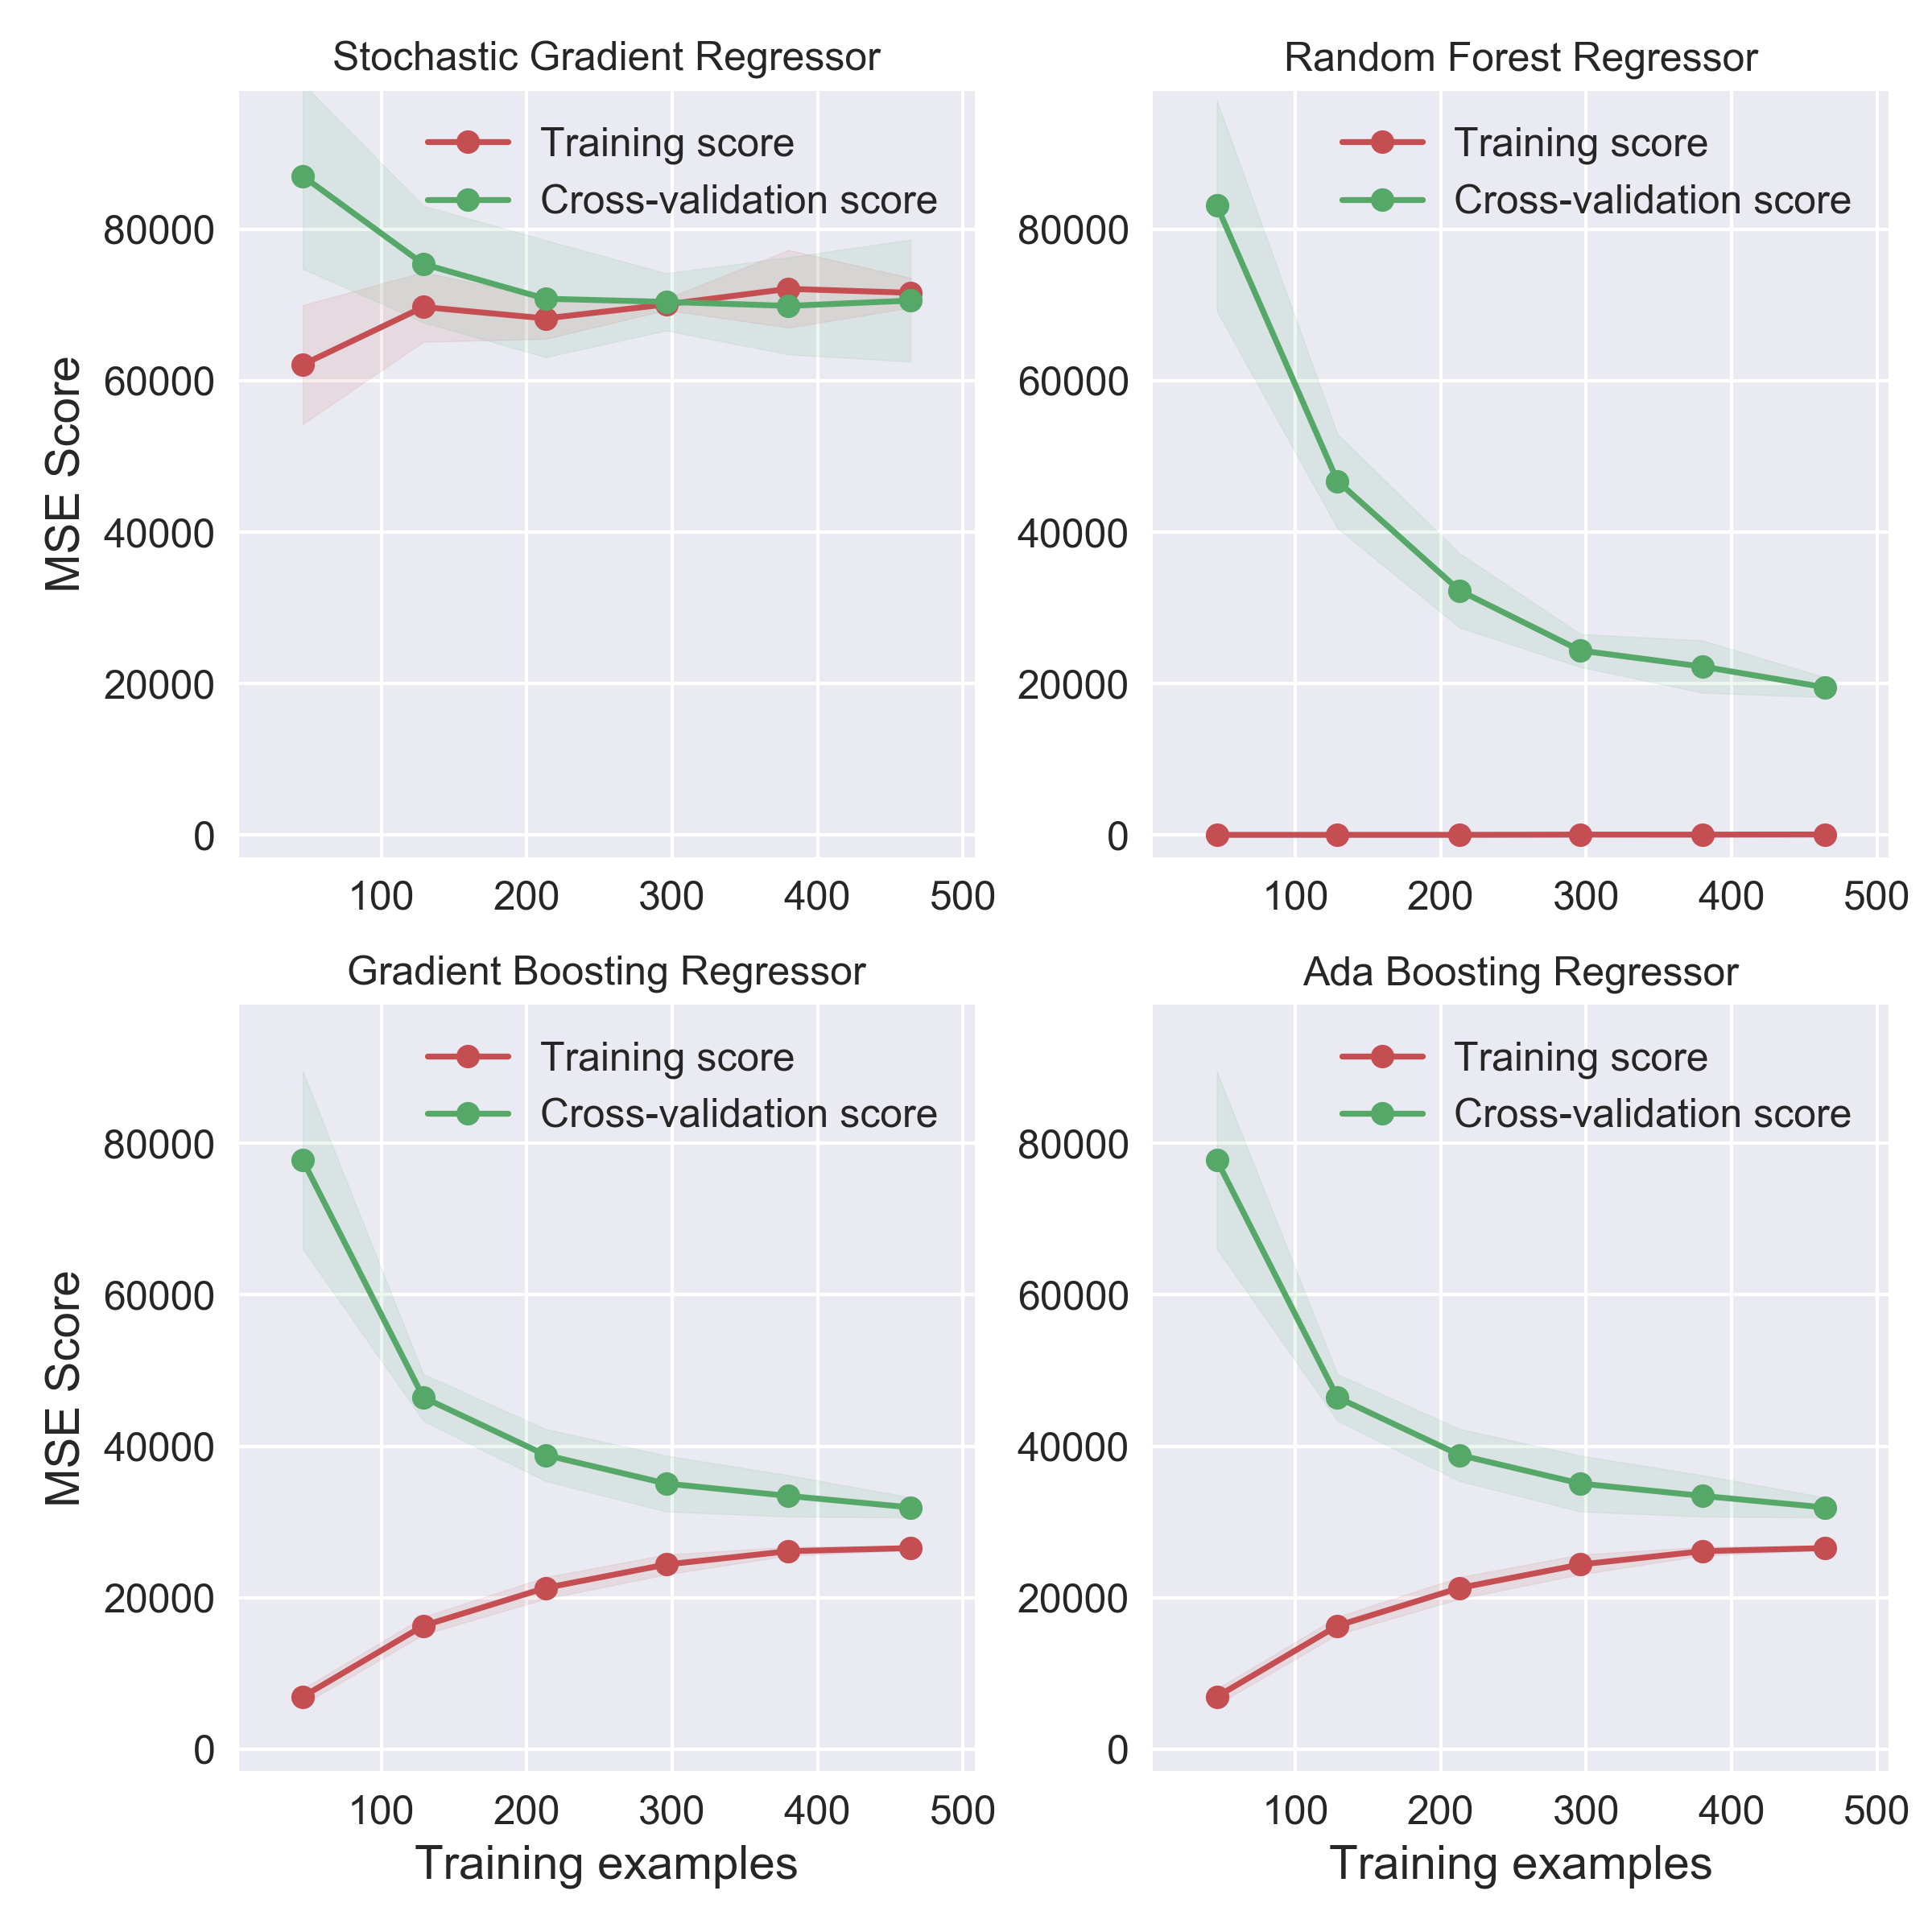

In [6]:
from IPython.display import Image
Image("./images/total_learning_curves.png",width=600, height=600)

**Model Overview**

In [7]:
from modelling import model_load
import pandas as pd

models = model_load()

labels = {}
for key, item in models.items():
    labels[key.upper()] = type(item.best_estimator_["reg"]).__name__
    
bm = pd.DataFrame.from_dict(labels, orient="index", columns=["model"])
bm

Loading Models


,model
EIRE,RandomForestRegressor
FRANCE,RandomForestRegressor
GERMANY,RandomForestRegressor
HONG_KONG,RandomForestRegressor
NETHERLANDS,RandomForestRegressor
NORWAY,RandomForestRegressor
PORTUGAL,RandomForestRegressor
SINGAPORE,AdaBoostRegressor
SPAIN,RandomForestRegressor
TOTAL,RandomForestRegressor


In [8]:
# to convert the jupyter to slides presentation run in the command window the following
# jupyter nbconvert --to slides --TemplateExporter.exclude_input=True part2-model-building-and-selection.ipynb